In [1]:
# -*- coding: utf-8 -*-
#  File: HW1_atom.ipynb
#  Project: 'OTUS Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 16-12-2021.

### Google colab specific part


Typical runtime on colab with initial 'toy' BO parameters is around 8 minutes and will increase linearly should you decide to play with them.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install -r '/content/drive/MyDrive/OTUS_HW1/requirements.txt'

# **$Homework 1$**  


Goals:   
- Compare four gradient boosting algorithms: sklearn GBT, XGBoost, CatBoost, LightGBM
- Implement EDA, preprocessing, and feature engineering
- Tune hyperparameters

Means:  
- All meaningful programming will be done in ATOM  
    https://tvdboom.github.io/ATOM/about/

Dataset:
- Student Performance on an entrance examination Data Set  https://archive.ics.uci.edu/ml/datasets/Student+Performance+on+an+entrance+examination

Abbreviations:
- EDA: exploratory data analysis
- BO: bayesian optimization
- FE: feature engineering
- DFS: deep feature synthesis

### Import libraries and setup notebook

In [4]:
import pandas as pd
import numpy as np
from atom import ATOMClassifier
from skopt.space.space import Real, Integer
from scipy.io import arff
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
import warnings
import sys
sys.path.append('/content/drive/MyDrive/OTUS_HW1/src')
from utilities import *

#### Miscellaneius settings 

In [5]:
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
# plt.rcParams['figure.figsize']=(10,5)
sns.set(rc = {'figure.figsize':(8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4
random_state = 17

#### Parameters of BO

In [6]:
ncalls = 7
n_initpoints = 3

#### Parameters of DFS and RFECV

In [7]:
n_features_dfs=100
n_features_rfecv=50

### Load data

In [8]:
data, meta = arff.loadarff('/content/drive/MyDrive/OTUS_HW1/data/CEE_DATA.arff')
df = pd.DataFrame(data).applymap(lambda x: x.decode('utf-8'))

#### Small bit of preprocessing - XGBoost needs special target encoding

In [9]:
df["Performance"] = df["Performance"].map(
    {'Average': 0, 'Good': 1, 'Vg': 2, 'Excellent': 3})

####  Split target from features

In [10]:
X = df[df.columns[1:]]
y = df[df.columns[0]]

### EDA

#### Basic dataset information

In [11]:
print(meta)
df.head(3)

Dataset: CEEData
	Performance's type is nominal, range is ('Excellent', 'Vg', 'Good', 'Average')
	Gender's type is nominal, range is ('male', 'female')
	Caste's type is nominal, range is ('General', 'OBC', 'SC', 'ST')
	coaching's type is nominal, range is ('NO', 'WA', 'OA')
	time's type is nominal, range is ('ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SEVEN')
	Class_ten_education's type is nominal, range is ('SEBA', 'OTHERS', 'CBSE')
	twelve_education's type is nominal, range is ('AHSEC', 'CBSE', 'OTHERS')
	medium's type is nominal, range is ('ENGLISH', 'OTHERS', 'ASSAMESE')
	Class_ X_Percentage's type is nominal, range is ('Excellent', 'Vg', 'Good', 'Average')
	Class_XII_Percentage's type is nominal, range is ('Excellent', 'Vg', 'Good', 'Average')
	Father_occupation's type is nominal, range is ('DOCTOR', 'SCHOOL_TEACHER', 'BUSINESS', 'COLLEGE_TEACHER', 'OTHERS', 'BANK_OFFICIAL', 'ENGINEER', 'CULTIVATOR')
	Mother_occupation's type is nominal, range is ('OTHERS', 'HOUSE_WIFE', 'SCHOOL_TEACH

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,3,male,General,NO,ONE,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS
1,3,male,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE
2,3,male,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           666 non-null    int64 
 1   Gender                666 non-null    object
 2   Caste                 666 non-null    object
 3   coaching              666 non-null    object
 4   time                  666 non-null    object
 5   Class_ten_education   666 non-null    object
 6   twelve_education      666 non-null    object
 7   medium                666 non-null    object
 8   Class_ X_Percentage   666 non-null    object
 9   Class_XII_Percentage  666 non-null    object
 10  Father_occupation     666 non-null    object
 11  Mother_occupation     666 non-null    object
dtypes: int64(1), object(11)
memory usage: 62.6+ KB


In [13]:
X.describe().T

,count,unique,top,freq
Gender,666,2,male,355
Caste,666,4,General,329
coaching,666,3,WA,449
time,666,6,TWO,368
Class_ten_education,666,3,SEBA,396
twelve_education,666,3,AHSEC,368
medium,666,3,ENGLISH,536
Class_ X_Percentage,666,4,Excellent,511
Class_XII_Percentage,666,4,Excellent,398
Father_occupation,666,8,OTHERS,277


#### Target values distribution

Target distribution by classes:


1    31.5 %
2    29.7 %
0    23.6 %
3    15.2 %
Name: Performance, dtype: object

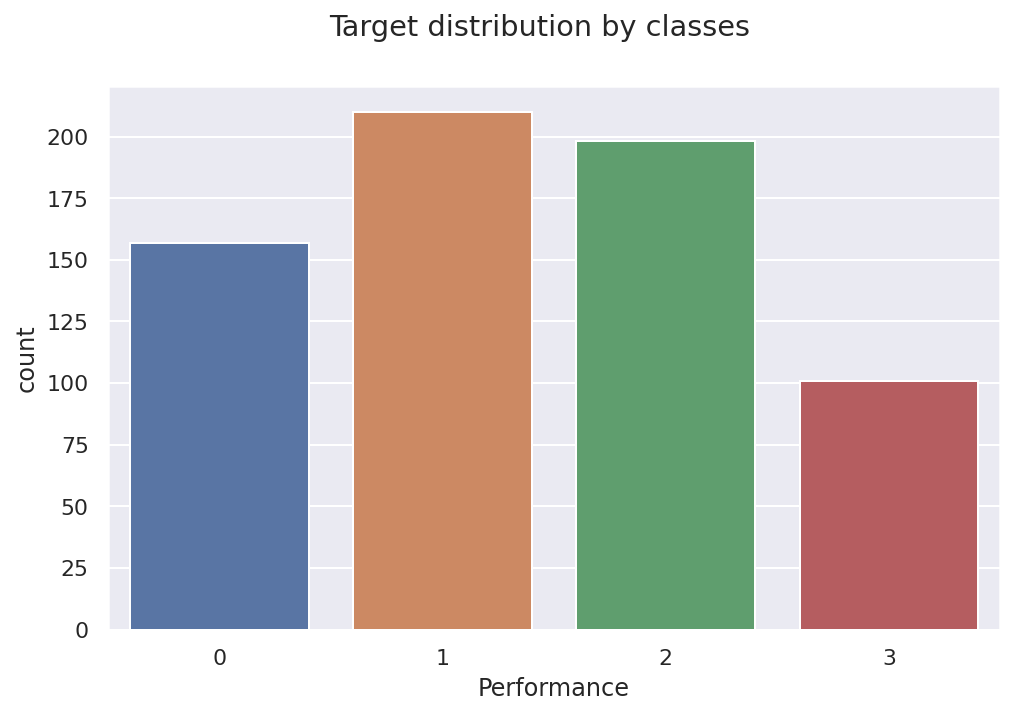

In [14]:
sns.countplot(df['Performance'], data=df)
plt.suptitle('Target distribution by classes')

print(f'Target distribution by classes:')
df["Performance"].value_counts(
    normalize=True).apply(lambda x: f'{x*100:.1f} %')

#### twelve_education and Caste features seem to be important

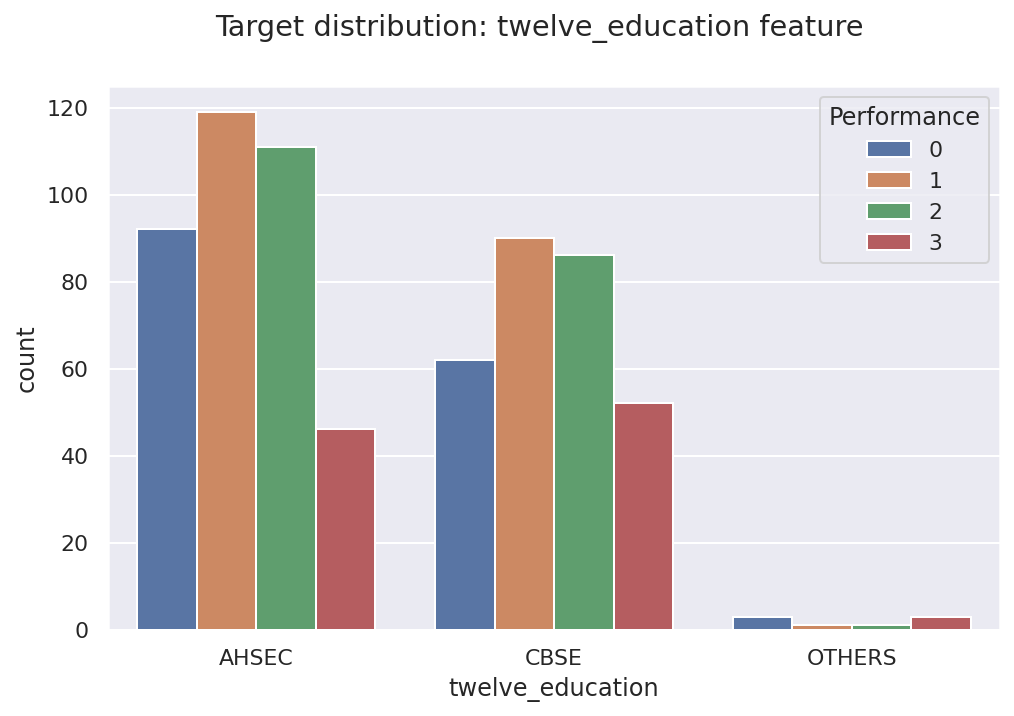

In [15]:
_ = sns.countplot(x=df['twelve_education'], hue=df['Performance'], data=df)
plt.suptitle('Target distribution: twelve_education feature')
plt.show()

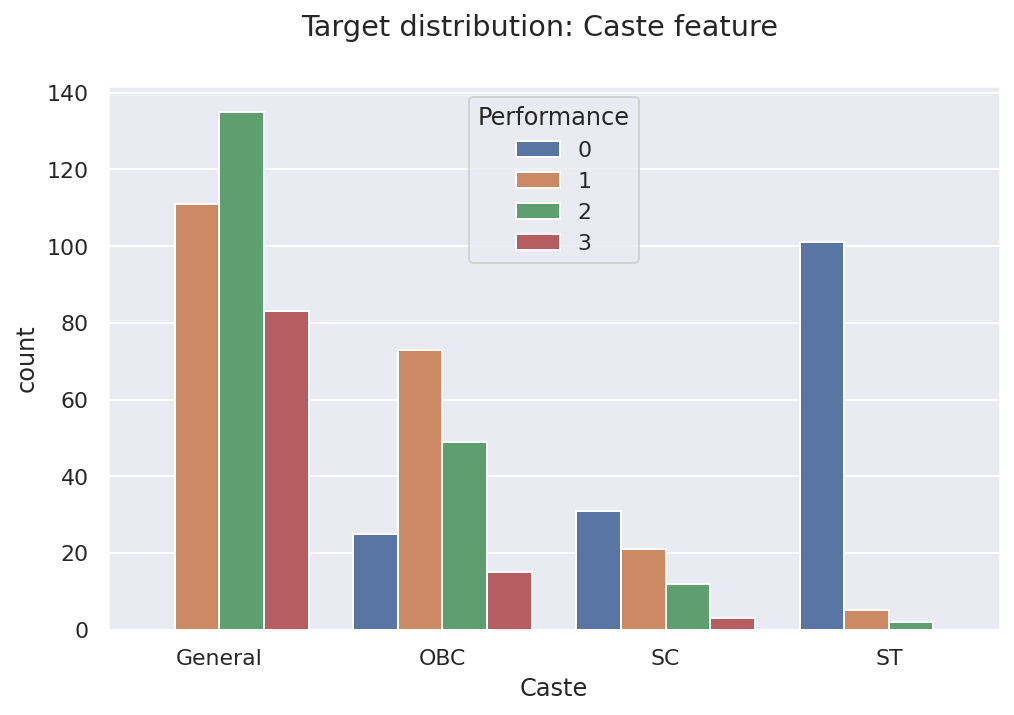

In [16]:
_ = sns.countplot(x=df['Caste'], hue=df['Performance'], data=df)
plt.suptitle('Target distribution: Caste feature')
plt.show()

#### Run profile report on the dataset

In [17]:
X.profile_report()

Observations:  
- Dataset has no missing values
- Roughly 10% of rows have duplicates - will ignore this, may be a coincidence
- All features are categorical with smallish number of unique values
- Many features have very uneven distributions with predominance of a single class
- Target values are distributed fairly equally between classes
- A number of feature pairs exhibit sizable correlation that may lead to their collinearity
- Only a few features have significant correlation with the target

### Pipeline

#### Initialise classifier

In [18]:
atom = ATOMClassifier(X, y, test_size=0.25, verbose=2,
                      warnings=False, random_state=random_state)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.

Dataset stats ==================== >>
Shape: (666, 12)
Scaled: False
Categorical features: 11 (100.0%)
Duplicate samples: 44 (6.6%)
-------------------------------------
Train set size: 500
Test set size: 166
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   157 (1.6) |   124 (1.8) |    33 (1.1) |
| 1  |   210 (2.1) |   156 (2.2) |    54 (1.7) |
| 2  |   198 (2.0) |   150 (2.1) |    48 (1.5) |
| 3  |   101 (1.0) |    70 (1.0) |    31 (1.0) |



#### Preprocessing - encode features

In [19]:
atom.encode()

Fitting Encoder...
Encoding categorical columns...
 --> Ordinal-encoding feature Gender. Contains 2 classes.
 --> OneHot-encoding feature Caste. Contains 4 classes.
 --> OneHot-encoding feature coaching. Contains 3 classes.
 --> OneHot-encoding feature time. Contains 6 classes.
 --> OneHot-encoding feature Class_ten_education. Contains 3 classes.
 --> OneHot-encoding feature twelve_education. Contains 3 classes.
 --> OneHot-encoding feature medium. Contains 3 classes.
 --> OneHot-encoding feature Class_ X_Percentage. Contains 4 classes.
 --> OneHot-encoding feature Class_XII_Percentage. Contains 4 classes.
 --> OneHot-encoding feature Father_occupation. Contains 8 classes.
 --> OneHot-encoding feature Mother_occupation. Contains 9 classes.


#### Setup Decision Tree classifier as a baseline model and check its performance

In [20]:
atom.run(
    models='tree',
    metric = ["roc_auc_ovr", "f1_weighted"]
)  


Training ========================= >>
Models: Tree
Metric: roc_auc_ovr, f1_weighted


Results for Decision Tree:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9964   f1_weighted: 0.9337
Test evaluation --> roc_auc_ovr: 0.6708   f1_weighted: 0.4791
Time elapsed: 0.040s
-------------------------------------------------
Total time: 0.040s


Final results ==================== >>
Duration: 0.041s
-------------------------------------
Decision Tree --> roc_auc_ovr: 0.6708   f1_weighted: 0.4791 ~


In [21]:
# Remove Decision Tree from the pipeline
atom.delete('tree')

Model deleted successfully!


#### Run the pipeline with default hyperparameters

##### Choose models and metrics

In [22]:
models = ['GBM', 'XGB', 'CATB', 'LGB']
metric = ["roc_auc_ovr", "f1_weighted"]

In [23]:
atom.branch = 'factory'
atom.run(
    models=models,
    metric=metric
)

New branch factory successfully created!

Training ========================= >>
Models: GBM, XGB, CatB, LGB
Metric: roc_auc_ovr, f1_weighted


Results for Gradient Boosting Machine:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9443   f1_weighted: 0.7843
Test evaluation --> roc_auc_ovr: 0.7957   f1_weighted: 0.5544
Time elapsed: 0.610s
-------------------------------------------------
Total time: 0.611s


Results for XGBoost:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9953   f1_weighted: 0.9319
Test evaluation --> roc_auc_ovr: 0.7516   f1_weighted: 0.4646
Time elapsed: 1.704s
-------------------------------------------------
Total time: 1.705s


Results for CatBoost:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9391   f1_weighted: 0.7616
Test evaluation --> roc_auc_ovr: 0.7966   f1_weighted: 0.5308
Time elapsed: 2.876s
------------------

#### Check train and test metrics

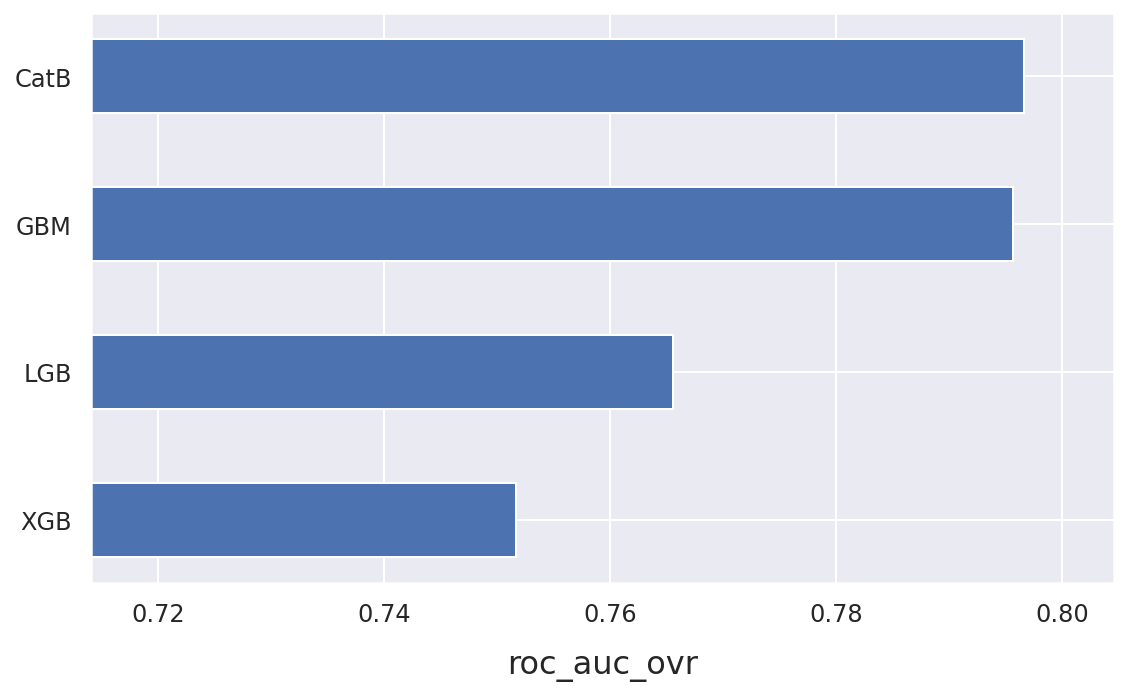

In [24]:
atom.plot_results(figsize=(8,5))
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:  
- All estimators perform better than baseline model - sanity check passed
- So far GBM and CatBoost seem more promising than XGBoost and LightGBM
- XGBoost and LightGBM are most likely overfitting

#### Check feature importance for one of estimators

 94%|=================== | 623/664 [00:13<00:00]       

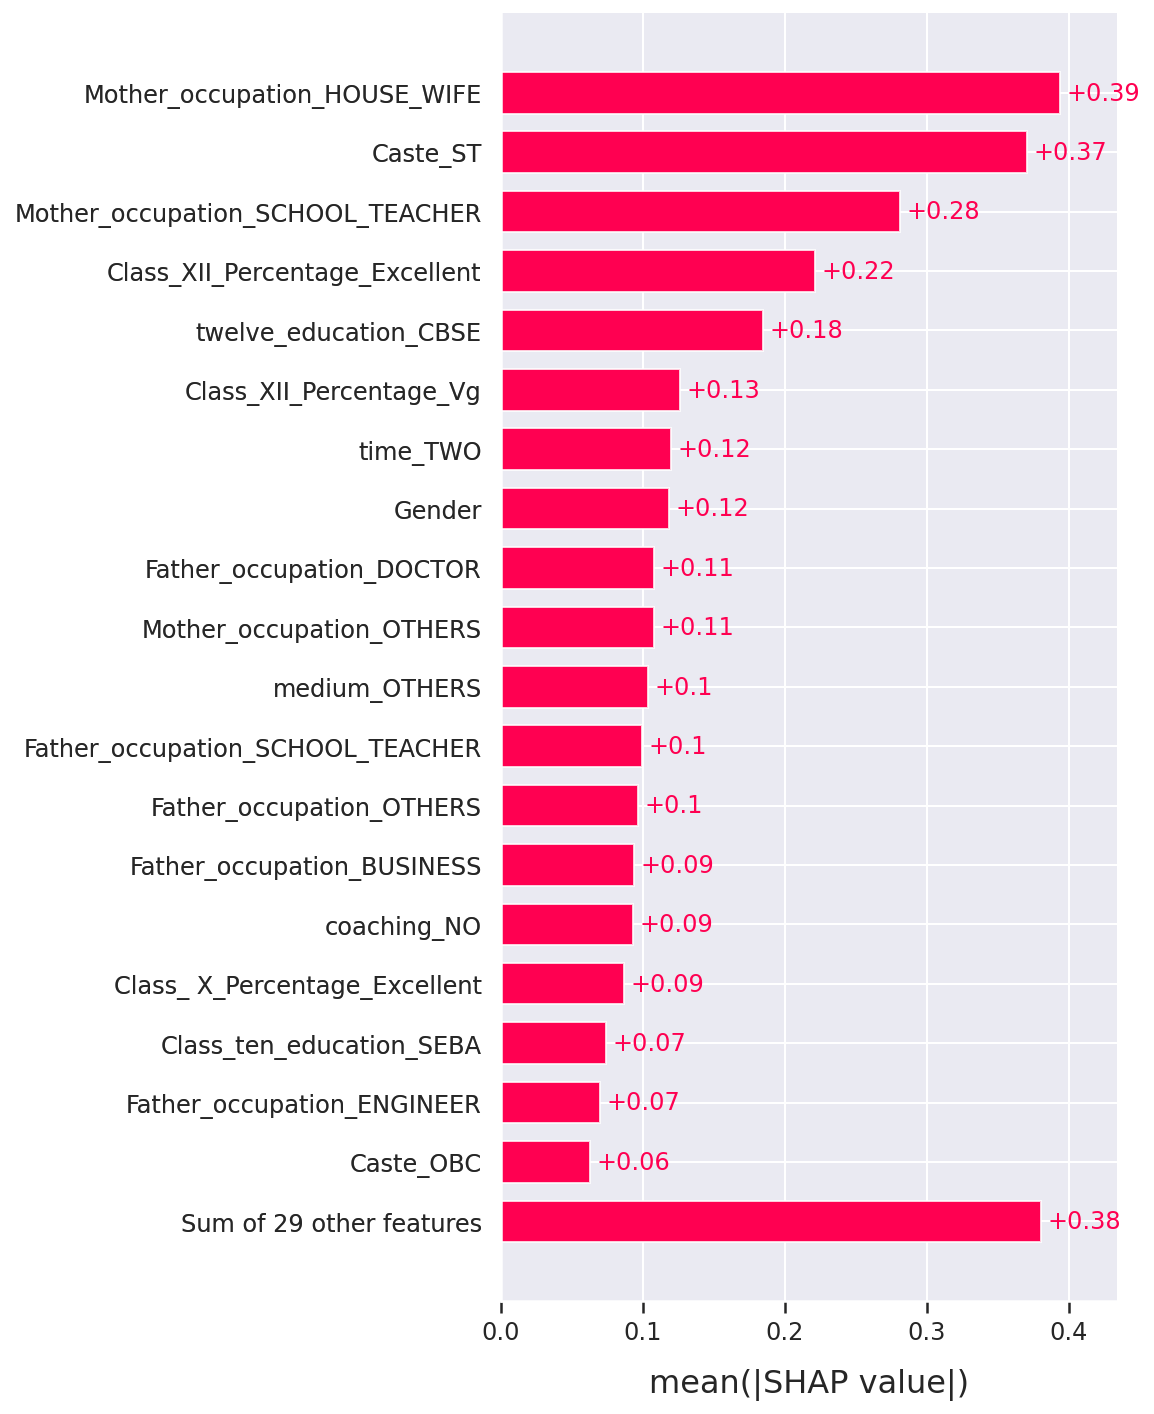

In [25]:
atom.bar_plot('LGB', show=20, figsize=(8,10)) # <-- doesn't work in mybinder, check why

#### Bayesian optimization of hyperparameters

In [26]:
atom.branch = "bo"
atom.run(
    models=["GBM", "XGB", "CATB", "LGB"],
    metric=metric,
    n_calls=ncalls,
    n_initial_points=n_initpoints,
    bo_params={
        "dimensions":[Integer(100, 1000, name="n_estimators"),
                Integer(2, 6, name="max_depth"),
                Real(0.01, 1, "log-uniform", name="learning_rate")],
        "base_estimator": "RF", "max_time": 10000,
    },
    n_bootstrap=5, verbose=1
)

Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

New branch bo successfully created!

Training ========================= >>
Models: GBM, XGB, CatB, LGB
Metric: roc_auc_ovr, f1_weighted


Running BO for Gradient Boosting Machine...


Iteration 7: 100%|██████████| 7/7 [00:21<00:00,  3.09s/it]



Results for Gradient Boosting Machine:         
Bayesian Optimization ---------------------------
Best call --> Initial point 1
Best parameters --> {'n_estimators': 341, 'max_depth': 3, 'learning_rate': 0.0136710136327914}
Best evaluation --> roc_auc_ovr: 0.7408   f1_weighted: 0.5354
Time elapsed: 21.622s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9062   f1_weighted: 0.6929
Test evaluation --> roc_auc_ovr: 0.7976   f1_weighted: 0.5042
Time elapsed: 1.808s


Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7739 ± 0.006   f1_weighted: 0.5002 ± 0.0287
Time elapsed: 8.785s
-------------------------------------------------
Total time: 32.220s


Running BO for XGBoost...


Iteration 7: 100%|██████████| 7/7 [00:43<00:00,  6.16s/it]



Results for XGBoost:         
Bayesian Optimization ---------------------------
Best call --> Initial point 1
Best parameters --> {'n_estimators': 341, 'max_depth': 3, 'learning_rate': 0.0136710136327914}
Best evaluation --> roc_auc_ovr: 0.7571   f1_weighted: 0.5599
Time elapsed: 43.133s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.8713   f1_weighted: 0.6185
Test evaluation --> roc_auc_ovr: 0.7953   f1_weighted: 0.515
Time elapsed: 4.344s


Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7767 ± 0.0061   f1_weighted: 0.5051 ± 0.0254
Time elapsed: 11.507s
-------------------------------------------------
Total time: 58.991s


Running BO for CatBoost...


Iteration 7: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]



Results for CatBoost:         
Bayesian Optimization ---------------------------
Best call --> Iteration 6
Best parameters --> {'n_estimators': 289, 'max_depth': 6, 'learning_rate': 0.14409256772011575}
Best evaluation --> roc_auc_ovr: 0.782   f1_weighted: 0.5711
Time elapsed: 6.118s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9206   f1_weighted: 0.7072
Test evaluation --> roc_auc_ovr: 0.787   f1_weighted: 0.5238
Time elapsed: 0.925s


Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7485 ± 0.0145   f1_weighted: 0.479 ± 0.0247
Time elapsed: 4.101s
-------------------------------------------------
Total time: 11.147s


Running BO for LightGBM...


Initial point 2:  14%|█▍        | 1/7 [00:00<00:02,  2.64it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 4:  43%|████▎     | 3/7 [00:01<00:01,  2.02it/s]    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 6:  71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 7: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]



Results for LightGBM:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7633   f1_weighted: 0.496
Time elapsed: 4.661s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9018   f1_weighted: 0.7025
Test evaluation --> roc_auc_ovr: 0.7755   f1_weighted: 0.4936
Time elapsed: 0.849s
Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7721 ± 0.0043   f1_weighted: 0.4856 ± 0.0128
Time elapsed: 2.513s
-------------------------------------------------
Total time: 8.028s


Final results ==================== >>
Duration: 1m:50s
-------------------------------------
Gradient Boosting Machine --> roc_auc_ovr: 0.7739 ± 0.006   f1_weighted: 0.5002 ± 0.0287
XGBoost                   --> roc_auc_ovr: 0.7767 ± 0.0061   f1_weighted: 0.5051 ± 0.0254 !
CatBoost              

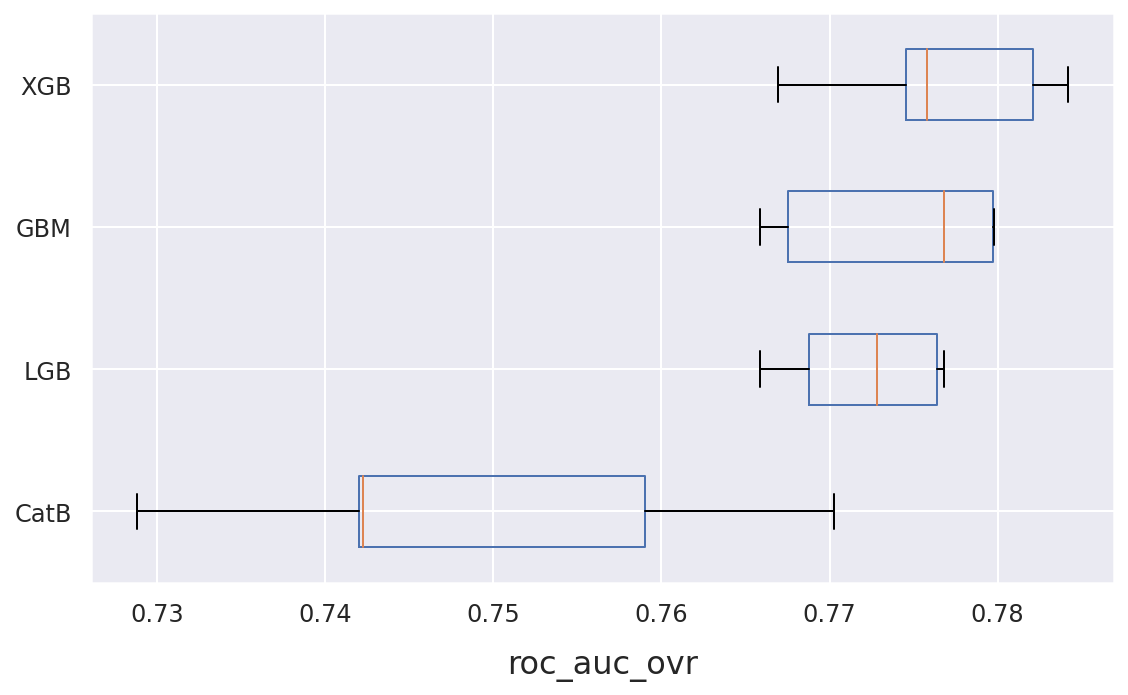

In [27]:
atom.plot_results(figsize=(8,5))
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:  
- BO leads to models performing more or less on par, with XGBoost leading in ROC_AUC and LightGBM in F1_weighted 
- Overall performance of models has not increased after H/P BO with n_calls=25, n_initial_points=10,  
    it takes several hundred of BO calls to reach ROC_AUC 0.8 and F1_weighted 0,51

### Feature engineering 

#### DFS in a separate pipeline branch

In [28]:
atom.verbose = 1
atom.branch = "fe"
atom.feature_generation("dfs", 
                        n_features=n_features_dfs, 
                        operators=["add", "sub", "mul"]),

New branch fe successfully created!
Fitting FeatureGenerator...
Creating new features...


#### Make feature selection: check for multicollinearity and use RFECV to reduce their number

In [29]:
atom.feature_selection(
    strategy="RFECV",
    solver="RF",
    n_features=n_features_rfecv,
    scoring="logloss",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...


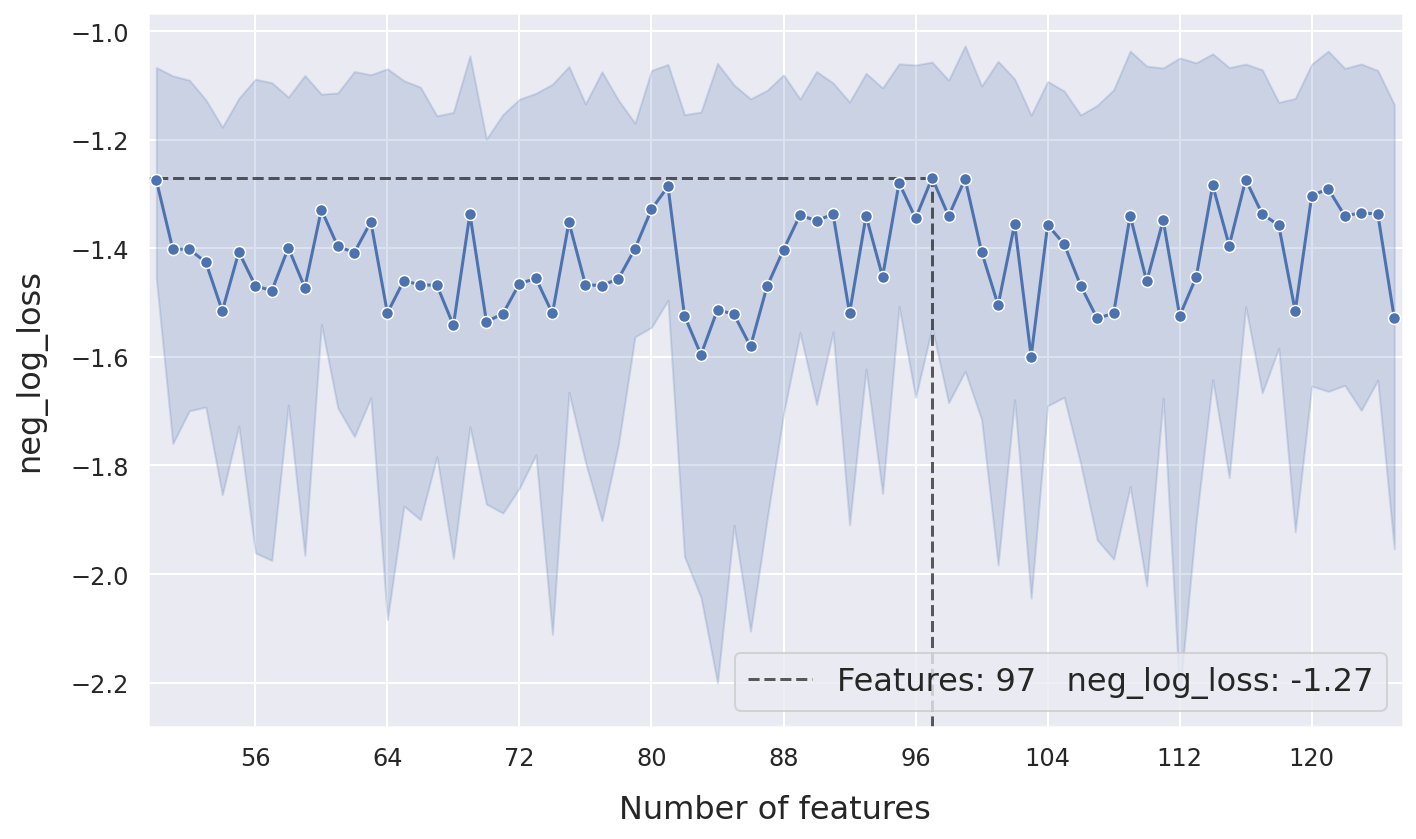

In [30]:
# After applying RFECV, plot the score per number of features
atom.plot_rfecv()

#### Run models with the new set of features

In [31]:
# Check models' performance now
# Add a tag to the model's acronym to not overwrite previous one

atom.run("GBM_fe")
atom.run("XGB_fe")
atom.run("CATB_fe")
atom.run("LGB_fe")


Training ========================= >>
Models: GBM_fe
Metric: roc_auc_ovr, f1_weighted


Results for Gradient Boosting Machine:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9552   f1_weighted: 0.798
Test evaluation --> roc_auc_ovr: 0.7656   f1_weighted: 0.5241
Time elapsed: 0.864s
-------------------------------------------------
Total time: 0.865s


Final results ==================== >>
Duration: 0.865s
-------------------------------------
Gradient Boosting Machine --> roc_auc_ovr: 0.7656   f1_weighted: 0.5241

Training ========================= >>
Models: XGB_fe
Metric: roc_auc_ovr, f1_weighted


Results for XGBoost:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9957   f1_weighted: 0.9319
Test evaluation --> roc_auc_ovr: 0.7476   f1_weighted: 0.4782
Time elapsed: 2.217s
-------------------------------------------------
Total time: 2.218s


Final results ==================== >>
Duration

#### Compare intermediate results

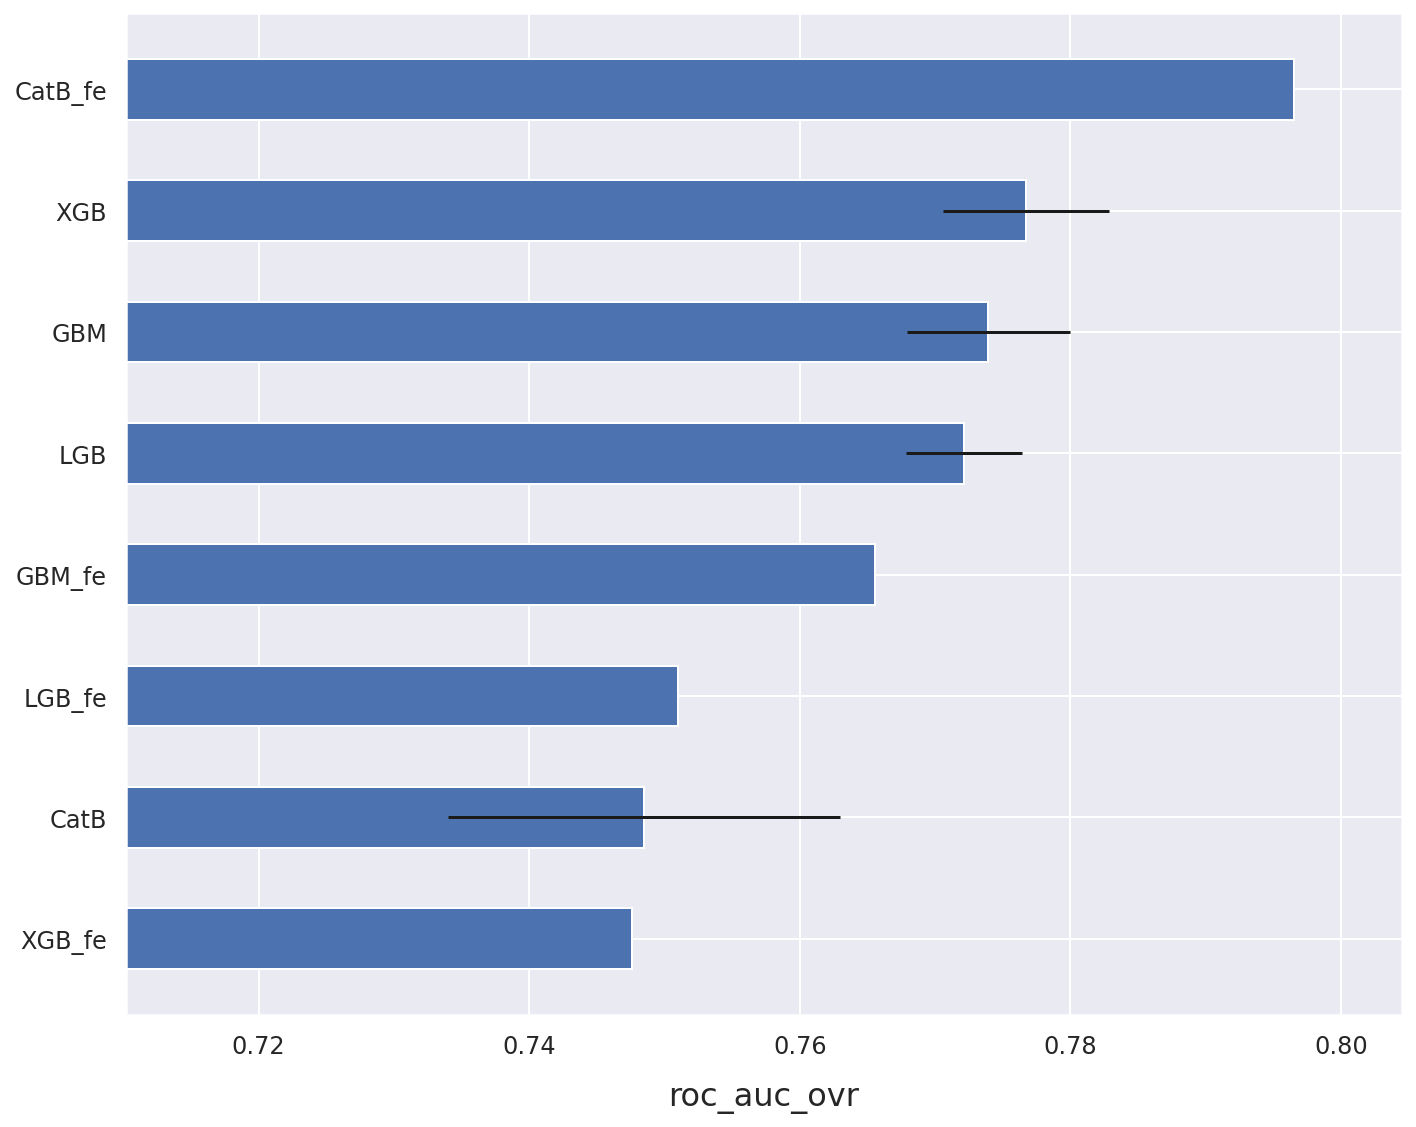

In [32]:
atom.plot_results()
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:
- Feature engineering doesn't show much promise as models with default parameters perform better in both metrics

#### Run FE-modified models and tune hyperparameters with bayesian optimization

Todo: eleminate line wrap in atom.run output

In [33]:
atom.branch = "fe_bo"

atom.run(
    models=["GBM_fe_bo", "XGB_fe_bo", "CATB_fe_bo", "LGB_fe_bo"],
    metric=metric,
    n_calls=ncalls,
    n_initial_points=n_initpoints,
    bo_params={"dimensions":[Integer(100, 1000, name="n_estimators"),
                Integer(2, 6, name="max_depth"),
                Real(0.01, 1, "log-uniform", name="learning_rate")],
        "base_estimator": "RF", "max_time": 10000
    },
    n_bootstrap=5, verbose=1
)

Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

New branch fe_bo successfully created!

Training ========================= >>
Models: GBM_fe_bo, XGB_fe_bo, CatB_fe_bo, LGB_fe_bo
Metric: roc_auc_ovr, f1_weighted


Running BO for Gradient Boosting Machine...


Iteration 7: 100%|██████████| 7/7 [00:29<00:00,  4.26s/it]



Results for Gradient Boosting Machine:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7555   f1_weighted: 0.4714
Time elapsed: 29.800s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9401   f1_weighted: 0.7699
Test evaluation --> roc_auc_ovr: 0.7675   f1_weighted: 0.5211
Time elapsed: 4.907s


Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7545 ± 0.0105   f1_weighted: 0.494 ± 0.0244
Time elapsed: 23.641s
-------------------------------------------------
Total time: 58.352s


Running BO for XGBoost...


Iteration 7: 100%|██████████| 7/7 [00:46<00:00,  6.64s/it]



Results for XGBoost:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7655   f1_weighted: 0.5163
Time elapsed: 46.462s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.8986   f1_weighted: 0.6678
Test evaluation --> roc_auc_ovr: 0.7868   f1_weighted: 0.5251
Time elapsed: 9.207s


Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.765 ± 0.0149   f1_weighted: 0.4978 ± 0.0344
Time elapsed: 26.545s
-------------------------------------------------
Total time: 1m:22s


Running BO for CatBoost...


Iteration 7: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]



Results for CatBoost:         
Bayesian Optimization ---------------------------
Best call --> Initial point 1
Best parameters --> {'n_estimators': 341, 'max_depth': 3, 'learning_rate': 0.0136710136327914}
Best evaluation --> roc_auc_ovr: 0.7931   f1_weighted: 0.5078
Time elapsed: 10.436s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.8351   f1_weighted: 0.5491
Test evaluation --> roc_auc_ovr: 0.7858   f1_weighted: 0.434
Time elapsed: 0.680s


Initial point 1:   0%|          | 0/7 [00:00<?, ?it/s]

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7761 ± 0.0051   f1_weighted: 0.46 ± 0.0224
Time elapsed: 2.736s
-------------------------------------------------
Total time: 13.855s


Running BO for LightGBM...


Initial point 2:  14%|█▍        | 1/7 [00:00<00:02,  2.05it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 4:  43%|████▎     | 3/7 [00:02<00:02,  1.60it/s]    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 6:  71%|███████▏  | 5/7 [00:04<00:01,  1.12it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 7: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]



Results for LightGBM:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7677   f1_weighted: 0.5654
Time elapsed: 5.766s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9035   f1_weighted: 0.7004
Test evaluation --> roc_auc_ovr: 0.7803   f1_weighted: 0.4885
Time elapsed: 1.032s
Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7584 ± 0.0165   f1_weighted: 0.4773 ± 0.0315
Time elapsed: 3.303s
-------------------------------------------------
Total time: 10.106s


Final results ==================== >>
Duration: 2m:45s
-------------------------------------
Gradient Boosting Machine --> roc_auc_ovr: 0.7545 ± 0.0105   f1_weighted: 0.494 ± 0.0244
XGBoost                   --> roc_auc_ovr: 0.765 ± 0.0149   f1_weighted: 0.4978 ± 0.0344
CatBoost               

#### Compare results - final table

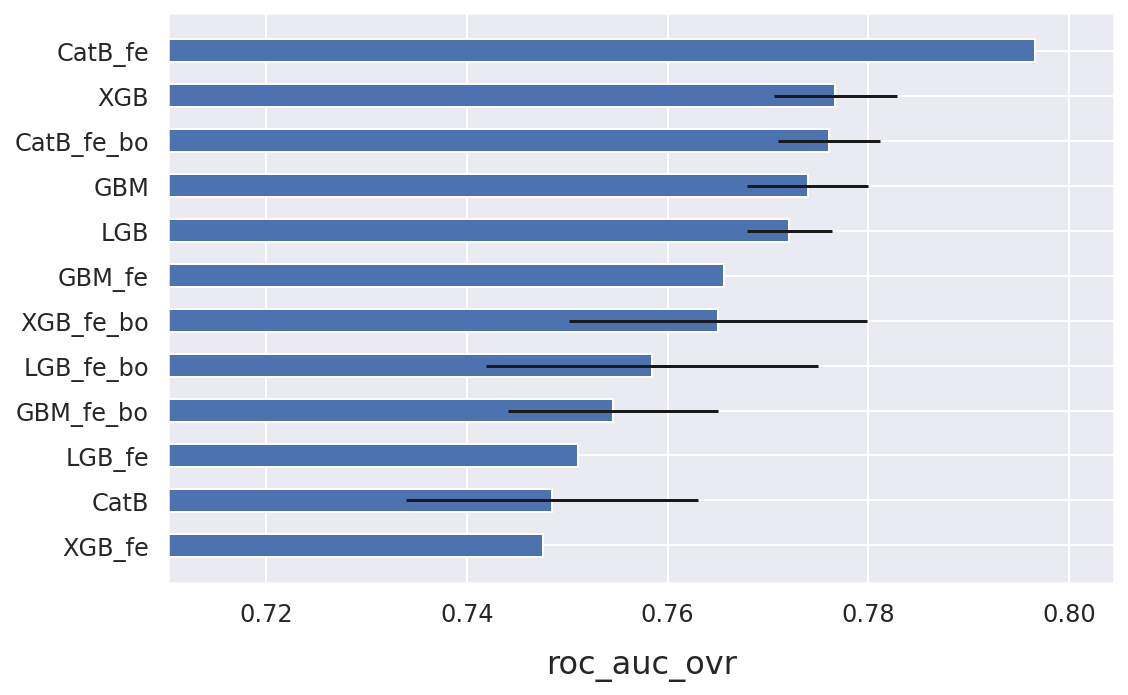

In [34]:
atom.plot_results(figsize=(8, 5))
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:  
- And the winner is ... CatBoost with factory settings, but a small change in parameters turns the table.  
No surprises here, as the number of BO calls is very small in this notebook.

#### Learning curves

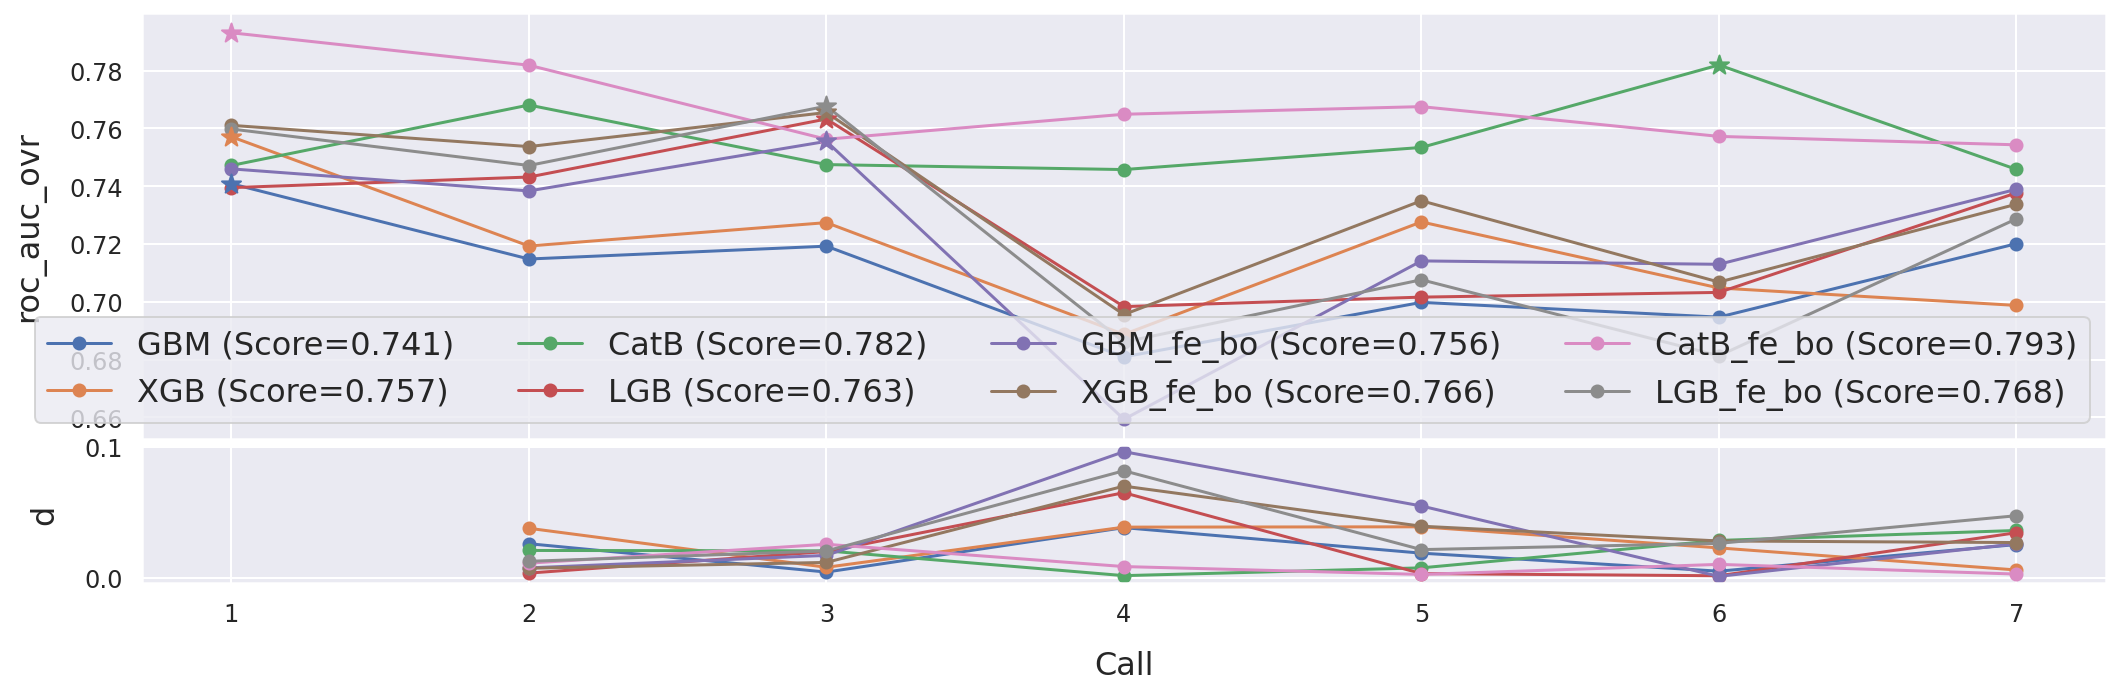

In [35]:
atom.plot_bo(figsize=(16,5))

In [36]:
# with atom.canvas(2, 2, title="Models evaluation"):
#     model_list = models
#     for m in model_list:
#         atom.plot_evals(m, title=f"{m}", figsize=(8,5)) # <-- doesn't work in mybinder/colab, check why

#### One model exploration - show-off

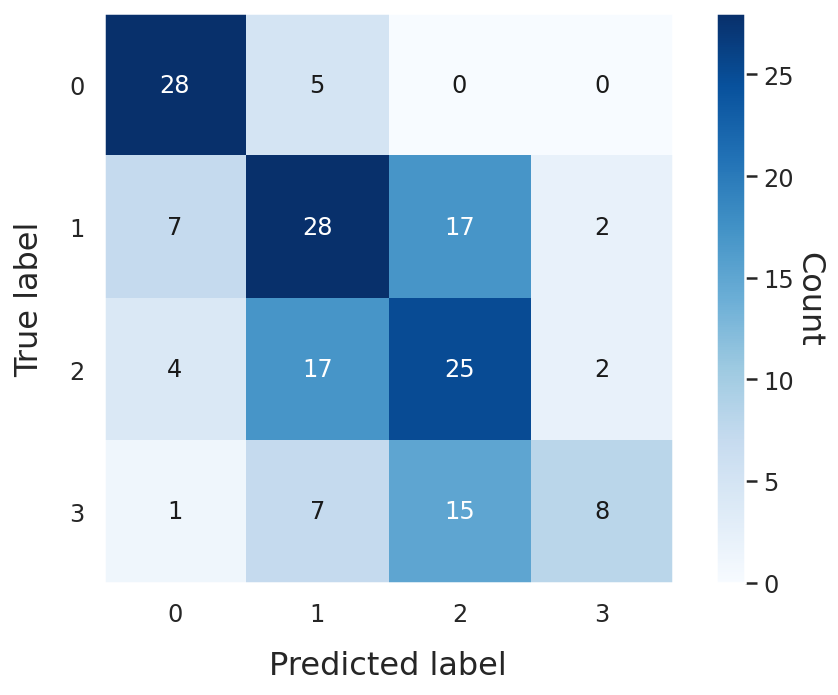

In [37]:
atom.plot_confusion_matrix("CATB", figsize=(8,5))

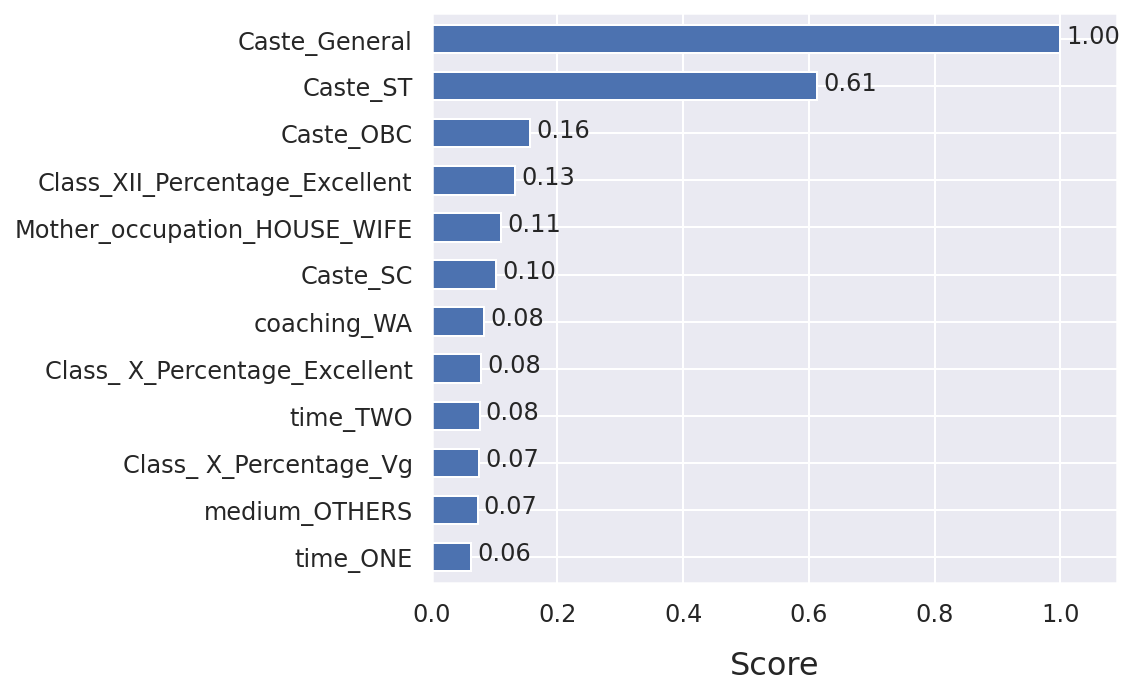

In [38]:
atom.plot_feature_importance("CATB", 12, figsize=(8,5))

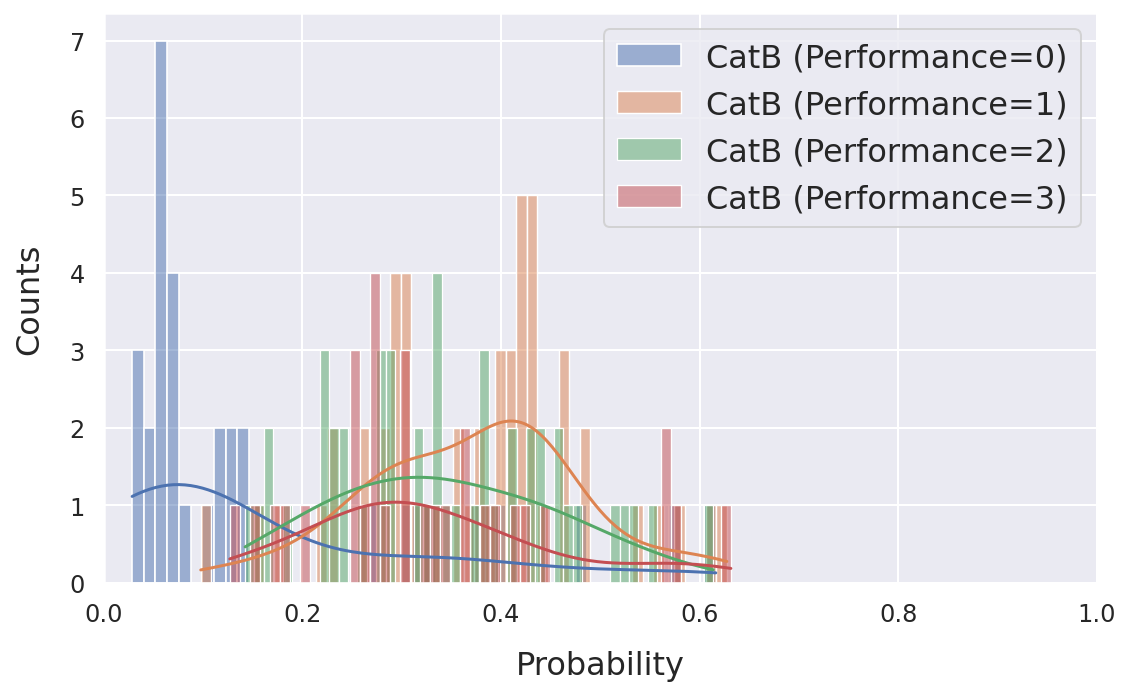

In [39]:
atom.plot_probabilities('CATB', figsize=(8,5))

### Final thoughts

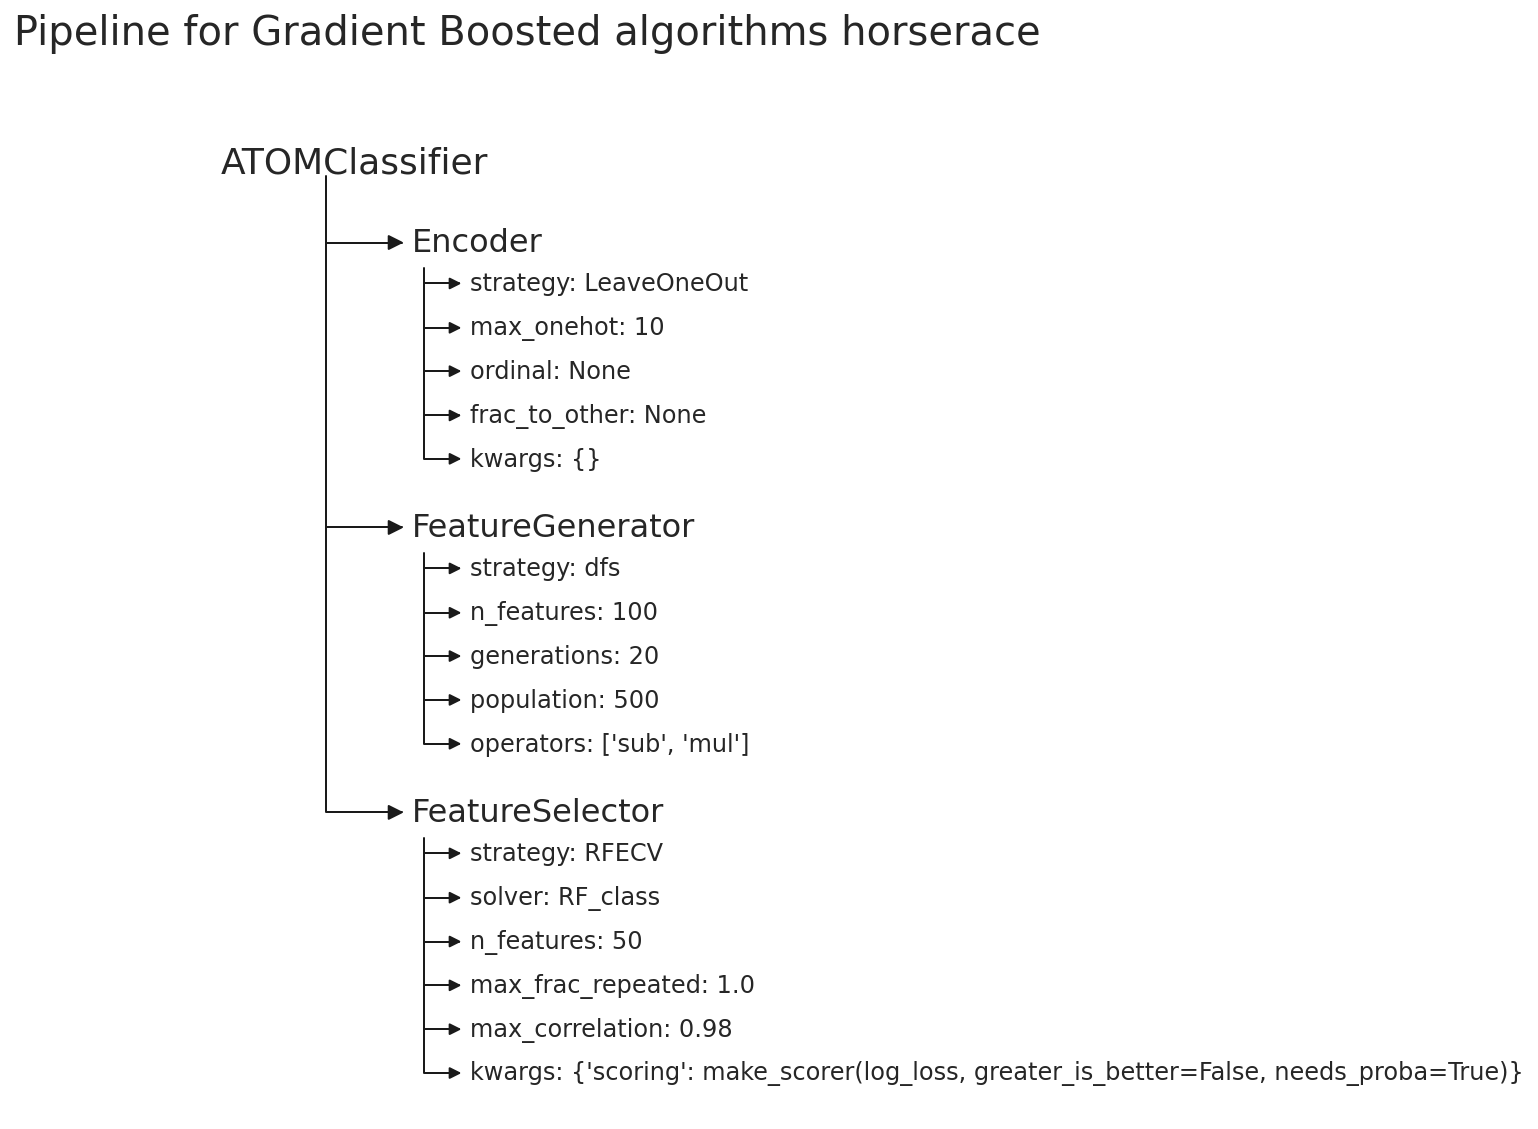

In [40]:
atom.plot_pipeline(title='Pipeline for Gradient Boosted algorithms horserace', figsize=(8,8))

Despite apparent failures of hyperparameters' optimization and feature engineering on a  
particular dataset, all gradient boosted models in question showed robust performance.  

Future steps:  
- drastically increase the number of calls for BO (200-500)
- give the models a try on a different dataset
- implement similar pipeline logic in sklearn with GridSearchCV (maybe)